# Trabajo Práctico 2 - Organización de Datos
## Competencia de Machine Learning
### Facultad de Ingeniería de la Universidad de Buenos Aires
### 95-58: Organización de Datos - 2do Cuat. 2018

#### Integrantes: Gonzalo Diz,  Ariel Windey, Gabriel Robles y Matías El Dócil




#### Objetivo
Determinar, para cada usuario presentado, cuál es la probabilidad de que ese
usuario realice una conversión en Trocafone en un periodo determinado.

#### Fuentes
El archivo "events_up_to_01062018.csv" contiene en el mismo formato utilizado en el TP1
información de eventos realizado en la plataforma para un conjunto de usuarios hasta el
31/05/2018.

Por otro lado el archivo "labels_training_set.csv" indica para un subconjunto de los
usuarios incluidos en el set de eventos "events_up_to_01062018.csv" si los mismos
realizaron una conversión (columna label = 1) o no (columna label = 0) desde el 01/06/2018
hasta el 15/06/2018.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as skl

%matplotlib inline

pd.set_option('display.max_columns', 51)

In [2]:
# Carga del set de datos de eventos
eventos = pd.read_csv('../dataset/events_up_to_01062018.csv', low_memory=False)
# Carga del set de datos de labels
labels = pd.read_csv('../dataset/labels_training_set.csv', low_memory=False)


In [3]:
eventos.shape

(2341681, 23)

In [4]:
eventos.sample(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
76022,2018-05-28 22:37:35,search engine hit,25e4177f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1811627,2018-03-27 22:45:45,generic listing,771149fa,NaN,NaN,NaN,NaN,NaN,NaN,"10211,13194,10309,10114,13179,10142,9960,10198...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318921,2018-05-22 09:15:13,viewed product,ebbf5372,NaN,15340.0,Samsung Galaxy S8,Excelente,64GB,Dourado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
748895,2018-05-06 14:08:11,viewed product,df1d60f5,NaN,9554.0,Sony Xperia Z3 Plus,Excelente,32GB,Branco,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1616812,2018-05-26 18:51:59,searched products,c3324a78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,iPhone 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Formateo los eventos
eventos['timestamp'] = pd.to_datetime(eventos['timestamp'])

## Feature: Marca Favorita

Para cada persona, se indicara su marca favorita, que significa la marca que mas checkouts, conversiones y viewed product.

Filtro de eventos las columnas person y model

In [6]:
marcas = eventos.loc[:, ['person', 'model']]

Agrego columnas que categorizan el modelo por marca

In [7]:
marcas['apple'] = (marcas['model'].str.contains('iphone', case=False)) | (marcas['model'].str.contains('ipad', case=False))
marcas['motorola'] = marcas['model'].str.contains('motorola', case=False)
marcas['samsung'] = marcas['model'].str.contains('samsung', case=False)
marcas['lg'] = marcas['model'].str.contains('lg', case=False)
marcas['blackberry'] = marcas['model'].str.contains('blackberry', case=False)
marcas['sony'] = marcas['model'].str.contains('sony', case=False)
marcas['asus'] = marcas['model'].str.contains('asus', case=False)
marcas['lenovo'] = marcas['model'].str.contains('lenovo', case=False)
marcas['quantum'] = marcas['model'].str.contains('quantum', case=False)

Los usuarios que nunca realizaron algun evento del tipo "checkout", "conversion" o "viewed product" no tendrán marcas asociadas, de ahí los valores NaN. Los descarto ya que no son representativos.

In [8]:
marcas = marcas[pd.notnull(marcas['model'])]
marcas.sample(15)

,person,model,apple,motorola,samsung,lg,blackberry,sony,asus,lenovo,quantum
1435546,5e25a7a1,Samsung Galaxy J5 Prime,False,False,True,False,False,False,False,False,False
960896,ffa9ac98,LG G3 D855,False,False,False,True,False,False,False,False,False
174799,73c8169b,Samsung Galaxy A9 Pro 2016,False,False,True,False,False,False,False,False,False
639149,1eca9842,Samsung Galaxy S7 Edge,False,False,True,False,False,False,False,False,False
47785,92b3c57c,Samsung Galaxy S6 Edge,False,False,True,False,False,False,False,False,False
1464584,11b1b119,Samsung Galaxy J5 Prime,False,False,True,False,False,False,False,False,False
252385,e4301d82,iPhone 6,True,False,False,False,False,False,False,False,False
346874,2c5c6b08,iPhone 6S,True,False,False,False,False,False,False,False,False
1746086,7df6a4d7,Samsung Galaxy Note 3,False,False,True,False,False,False,False,False,False
935935,4105b21e,iPhone 5s,True,False,False,False,False,False,False,False,False


In [9]:
marcas.loc[(marcas['apple'] == False) & (marcas['motorola'] == False) & (marcas['samsung'] == False) & (marcas['lg'] == False) & (marcas['blackberry'] == False) & (marcas['sony'] == False) & (marcas['asus'] == False) & (marcas['lenovo'] == False) & (marcas['quantum'] == False), :]['model'].value_counts()

Xiaomi Redmi 2      1
Outros TV LED 15    1
Name: model, dtype: int64

Ya no se necesita la columna "modelo", pues tenemos cada marca categorizada por columnas.

In [10]:
marcas = marcas.drop('model', axis=1)
marcas.head()

,person,apple,motorola,samsung,lg,blackberry,sony,asus,lenovo,quantum
0,4886f805,False,False,True,False,False,False,False,False,False
1,ad93850f,True,False,False,False,False,False,False,False,False
2,0297fc1e,True,False,False,False,False,False,False,False,False
3,2d681dd8,True,False,False,False,False,False,False,False,False
4,cccea85e,False,False,False,True,False,False,False,False,False


Agrupamos por persona sumando cada tipo de marca asociada.

In [11]:
marcas = marcas.groupby('person').agg({'apple':'sum', 'motorola':'sum', 'samsung': 'sum', 'lg':'sum', 'blackberry':'sum', 'sony':'sum', 'asus':'sum', 'lenovo':'sum', 'quantum':'sum'})

Las sumas vuelven en tipo object, las pasamos a float.

In [12]:
marcas = marcas.astype('float64')

Nos quedamos con la marca favorita de cada persona con idmax(axis=1)

In [13]:
marcas['marca_favorita'] = marcas.idxmax(axis=1)
marcas.sample(10)
marcas = marcas.reset_index()

In [14]:
marcas_favoritas = marcas.loc[:, ['person', 'marca_favorita']]
marcas_favoritas.head()

,person,marca_favorita
0,0008ed71,apple
1,00091926,apple
2,00091a7a,apple
3,000ba417,samsung
4,000c79fe,apple


In [15]:
marcas_favoritas['marca_favorita'].value_counts()

apple       16613
samsung     16410
motorola     4406
lg            434
sony          192
lenovo        158
asus           32
quantum        11
Name: marca_favorita, dtype: int64

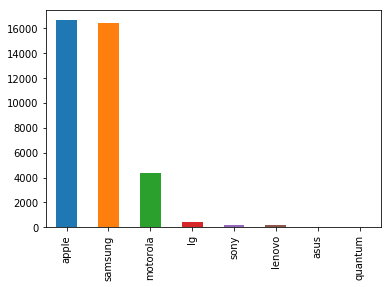

In [40]:
marcas_favoritas['marca_favorita'].value_counts().plot.bar()

Liberamos recursos

In [17]:
marcas = 0

## Feature: Actividad de Usuario

Para cada persona, se creará una categoría que indicará su nivel de actividad en la plataforma. Para elaborar la misma, se medirá la cantidad de eventos totales generados por un usuario, y se tendrá el tiempo que tiene el usuario en la plataforma (diferencia de tiempo en dias desde el primer evento generado al último). Finalmente se creará una métrica que será CANTIDAD_EVENTOS_TOTALES / DIAS_EN_LA_PLATAFORMA. En base a este valor se categorizarán los usuarios.

In [18]:
eventos.sample(5)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,search_term,staticpage,campaign_source,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
39877,2018-05-12 15:23:43,viewed product,8808e6a9,NaN,12520.0,Motorola Moto G5,Bom,32GB,Platinum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1617229,2018-05-26 18:31:26,search engine hit,dfe7c58a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Google,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1453403,2018-05-22 01:33:15,viewed product,2043bab2,NaN,8443.0,Samsung Galaxy S7,Bom,32GB,Preto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526961,2018-05-10 01:24:04,viewed product,ef8f7e14,NaN,1397.0,iPhone 6 Plus,Excelente,64GB,Prateado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601485,2018-05-16 13:51:54,searched products,bb7d778b,NaN,NaN,NaN,NaN,NaN,NaN,"7631,9217,5135,4969,7616,5004,11471",Moto g 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
actividad_timestamp = eventos[['person', 'timestamp']] 

#### Obtengo la cantidad de días que cada usuario tiene en la plataforma

In [20]:
dias_en_plataforma = actividad_timestamp.groupby('person').agg({'timestamp': ['min','max']}).reset_index()
dias_en_plataforma.columns = ['person', 'min', 'max']
dias_en_plataforma['dias_en_plataforma'] = dias_en_plataforma['max'] - dias_en_plataforma['min']
dias_en_plataforma['dias_en_plataforma_float'] = (dias_en_plataforma['dias_en_plataforma'].dt.total_seconds() / (60*60*24))
dias_en_plataforma = dias_en_plataforma.drop(['min','max','dias_en_plataforma'],axis=1)
dias_en_plataforma = dias_en_plataforma.rename(columns={'dias_en_plataforma_float':'dias_en_plataforma'})
dias_en_plataforma.head()

,person,dias_en_plataforma
0,0008ed71,0.167245
1,00091926,27.905255
2,00091a7a,0.004016
3,000ba417,9.081678
4,000c79fe,0.007176


In [22]:
dias_en_plataforma.shape

(38829, 2)

In [45]:
dias_en_plataforma.mean()

dias_en_plataforma    15.309919
dtype: float64

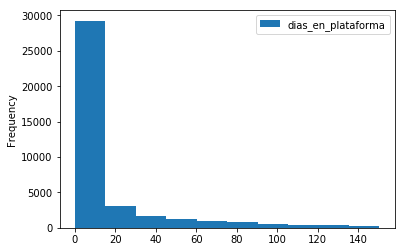

In [44]:
dias_en_plataforma.plot.hist()

In [64]:
dias_en_plataforma.to_csv('dias_en_plataforma_por_persona.csv', index=False)

#### Obtengo la cantidad de eventos en días distintos que tiene cada persona

In [24]:
eventos['fecha'] = eventos['timestamp'].dt.date

Obtengo un dataframe con persona y día en que realizó un evento, con duplicados.

In [25]:
dias_con_eventos = eventos.loc[:,['person', 'fecha']]
dias_con_eventos.shape

(2341681, 2)

In [26]:
dias_con_eventos.head()

,person,fecha
0,4886f805,2018-05-18
1,ad93850f,2018-05-18
2,0297fc1e,2018-05-18
3,2d681dd8,2018-05-18
4,cccea85e,2018-05-18


Quito los duplicados

In [27]:
dias_con_eventos = dias_con_eventos.drop_duplicates()
dias_con_eventos.shape

(138421, 2)

In [28]:
dias_con_eventos_agg = dias_con_eventos.groupby('person').count().reset_index()
dias_con_eventos_agg = dias_con_eventos_agg.rename(columns={'fecha':'dias_distintos_con_eventos'})

In [29]:
dias_con_eventos_agg.head()

,person,dias_distintos_con_eventos
0,0008ed71,1
1,00091926,22
2,00091a7a,1
3,000ba417,3
4,000c79fe,1


In [30]:
dias_con_eventos_agg.shape

(38829, 2)

In [46]:
dias_con_eventos_agg.mean()

dias_distintos_con_eventos    3.564887
dtype: float64

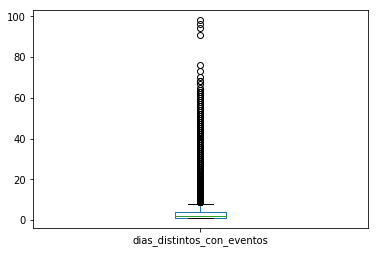

In [55]:
dias_con_eventos_agg.plot.box()

In [65]:
dias_con_eventos_agg.to_csv('dias_distintos_con_eventos_por_persona.csv', index=False)

#### Obtengo la cantidad de eventos totales por persona

In [56]:
actividad = eventos.loc[:, ['person', 'event']]
actividad.head()

,person,event
0,4886f805,viewed product
1,ad93850f,viewed product
2,0297fc1e,viewed product
3,2d681dd8,viewed product
4,cccea85e,viewed product


In [57]:
eventos_por_persona = actividad.groupby(['person']).count().reset_index()
eventos_por_persona = eventos_por_persona.rename(columns={'event':'eventos_totales_generados'})
eventos_por_persona.head()

,person,eventos_totales_generados
0,0008ed71,6
1,00091926,448
2,00091a7a,10
3,000ba417,206
4,000c79fe,17


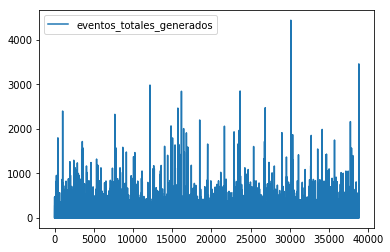

In [58]:
eventos_por_persona.plot()

In [59]:
eventos_por_persona.mean()

eventos_totales_generados    60.307528
dtype: float64

In [66]:
eventos_por_persona.to_csv('eventos_totales_por_persona.csv', index=False)

#### Con las 3 métricas anteriores, construyo un criterio para definir la actividad de un usuario